## Data Loading

In [1]:
# Load Dataset
import tensorflow as tf

# Balance
train_dir = '/kaggle/input/tomatodiseasedataset/TomatoDiseaseSplit/train'
val_dir = '/kaggle/input/tomatodiseasedataset/TomatoDiseaseSplit/val'
test_dir = '/kaggle/input/tomatodiseasedataset/TomatoDiseaseSplit/test'

# Define parameters
BATCH_SIZE = 32
IMG_SIZE = (256, 256)  # Image dimensions

# Load the train dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                    shuffle=True,
                                                                    batch_size=BATCH_SIZE,
                                                                    image_size=IMG_SIZE)

# Load the validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                  shuffle=True,
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=IMG_SIZE)

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                   shuffle=False,
                                                                   batch_size=BATCH_SIZE,
                                                                   image_size=IMG_SIZE)

Found 9973 files belonging to 10 classes.
Found 1595 files belonging to 10 classes.
Found 1607 files belonging to 10 classes.


In [2]:
# Print class names
class_names = train_dataset.class_names
print("Class names:", class_names)

Class names: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [3]:
# Define normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to each dataset
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [4]:
# Define input shape, number of classes and batch size
input_shape = (256, 256, 3)
num_classes = 10  
batch_size = 32

## Hyperparameter Tuning

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the hypermodel
def build_hypermodel(hp):
    inputs = layers.Input(shape=(256, 256, 3))  # Adjust shape for your data

    # Convolutional Block 1
    x = layers.Conv2D(
        filters=hp.Int("conv1_filters", min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation="relu",
        padding="same"
    )(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convolutional Block 2
    x = layers.Conv2D(
        filters=hp.Int("conv2_filters", min_value=64, max_value=256, step=64),
        kernel_size=(3, 3),
        activation="relu",
        padding="same"
    )(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convolutional Block 3
    x = layers.Conv2D(
        filters=hp.Int("conv3_filters", min_value=128, max_value=512, step=128),
        kernel_size=(3, 3),
        activation="relu",
        padding="same"
    )(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Self-Attention Layer
    attention_output = layers.MultiHeadAttention(
        num_heads=hp.Choice("num_heads", values=[2, 4, 8]), 
        key_dim=hp.Int("key_dim", min_value=64, max_value=256, step=64)
    )(x, x)
    x = layers.Add()([x, attention_output])  # Residual connection

    # Fully Connected Layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(hp.Int("dense_units", min_value=64, max_value=256, step=64), activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=hp.Choice("learning_rate", [1e-3, 1e-4, 1e-5])),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [ ]:
# Instantiate the tuner
tuner = kt.RandomSearch(
    build_hypermodel,
    objective="val_accuracy",
    max_trials=10, 
    directory="my_tuner_dir",
    project_name="sacnn_hyperparameter_tuning"
)

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Perform the search
tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping],
)

Trial 20 Complete [00h 09m 26s]
val_accuracy: 0.5699059367179871

Best val_accuracy So Far: 0.9642633199691772
Total elapsed time: 05h 44m 55s


In [6]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"Conv1 Filters: {best_hps.get('conv1_filters')}")
print(f"Conv2 Filters: {best_hps.get('conv2_filters')}")
print(f"Conv3 Filters: {best_hps.get('conv3_filters')}")
print(f"Attention Heads: {best_hps.get('num_heads')}")
print(f"Attention Key Dimension: {best_hps.get('key_dim')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

Best Hyperparameters:
Conv1 Filters: 64
Conv2 Filters: 256
Conv3 Filters: 384
Attention Heads: 8
Attention Key Dimension: 64
Dense Units: 192
Learning Rate: 0.001


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build the model with the best hyperparameters
sa_cnn_model_tuning = tuner.hypermodel.build(best_hps)

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model on the dataset
history = sa_cnn_model_tuning.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]  
)

Epoch 1/30
  1/312 ━━━━━━━━━━━━━━━━━━━━ 20:27 4s/step - accuracy: 0.1562 - loss: 2.2969

I0000 00:00:1732006546.518362      72 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads



312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.2680 - loss: 1.9204

I0000 00:00:1732006603.012875      71 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads



312/312 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - accuracy: 0.2684 - loss: 1.9192 - val_accuracy: 0.5987 - val_loss: 1.1211 - learning_rate: 0.0010
Epoch 2/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 56s 179ms/step - accuracy: 0.6145 - loss: 1.0445 - val_accuracy: 0.6552 - val_loss: 0.9160 - learning_rate: 0.0010
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 56s 179ms/step - accuracy: 0.7315 - loss: 0.7619 - val_accuracy: 0.7994 - val_loss: 0.5561 - learning_rate: 0.0010
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 56s 179ms/step - accuracy: 0.8028 - loss: 0.5506 - val_accuracy: 0.8075 - val_loss: 0.5502 - learning_rate: 0.0010
Epoch 5/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 56s 179ms/step - accuracy: 0.8304 - loss: 0.4678 - val_accuracy: 0.8846 - val_loss: 0.3451 - learning_rate: 0.0010
Epoch 6/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 56s 179ms/step - accuracy: 0.8781 - loss: 0.3602 - val_accuracy: 0.8884 - val_loss: 0.3305 - learning_rate: 0.0010
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 56s 179ms/step - accuracy: 0.9047 - loss:

In [8]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = sa_cnn_model_tuning.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9604 - loss: 0.1243
Test accuracy: 0.9645301699638367
Test loss: 0.10639365017414093


In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Generate predictions for the test dataset
predictions = sa_cnn_model_tuning.predict(test_dataset)
predicted_classes = tf.argmax(predictions, axis=1)  # Get the predicted class labels
true_classes = tf.concat([y for x, y in test_dataset], axis=0)  # True labels from the test dataset

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step
Precision: 0.964922707931158
Recall: 0.9645301804604853
F1 Score: 0.964528107059463


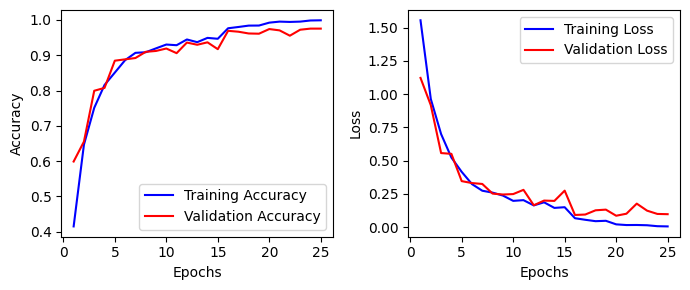

In [10]:
import matplotlib.pyplot as plt

# Retrieve model training and validation metrics from the history object
acc2 = history.history['accuracy'] #training accuracy
val_acc = history.history['val_accuracy'] #validation accuracy
loss2 = history.history['loss'] #training loss
val_loss = history.history['val_loss'] #validation loss

# Define the range for epochs
epochs = range(1,len(acc2)+1)

# Plot training and validation accuracy on the first subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

# Plot training and validation accuracy on the first subplot
axes[0].plot(epochs, acc2, 'b', label='Training Accuracy')
axes[0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot training and validation loss on the second subplot
axes[1].plot(epochs, loss2, 'b', label='Training Loss')
axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [11]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions on the test dataset
y_pred = sa_cnn_model_tuning.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Get true labels from test_dataset
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Generate classification report with meaningful class names
report = classification_report(test_labels, y_pred_classes, target_names=class_names)
print(report)

51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step
                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.96      0.97      0.97       214
                        Tomato_Early_blight       0.91      0.93      0.92       100
                         Tomato_Late_blight       0.97      0.93      0.95       191
                           Tomato_Leaf_Mold       0.94      1.00      0.97        96
                  Tomato_Septoria_leaf_spot       0.99      0.95      0.97       178
Tomato_Spider_mites_Two_spotted_spider_mite       0.94      0.97      0.96       169
                        Tomato__Target_Spot       0.99      0.95      0.97       141
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.96      0.97      0.97       321
                Tomato__Tomato_mosaic_virus       1.00      1.00      1.00        38
                             Tomato_healthy       0.99      0.99      0.99       159

                       

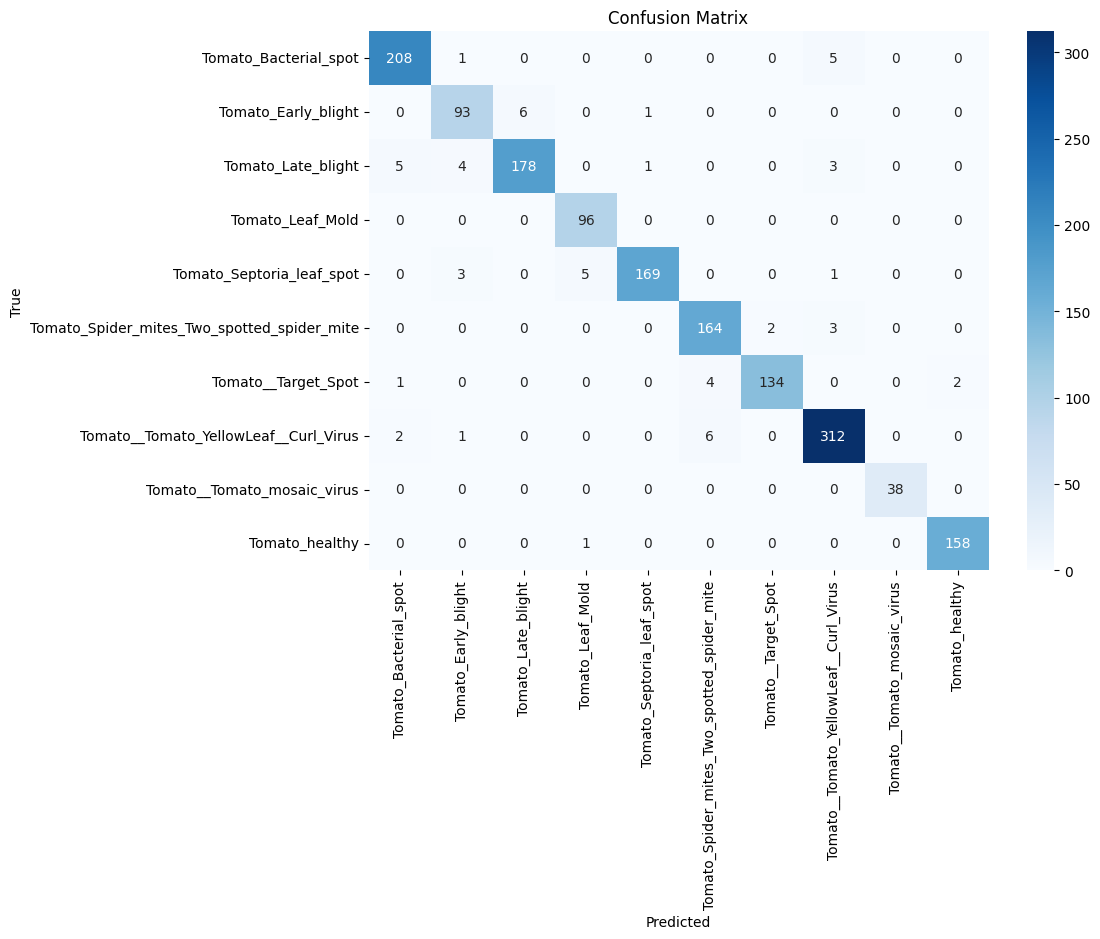

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()